# Final Upload Model - Random Forrest Regressor No Outliers

--- 

In this notebook we put together all relevant notebooks to make our predicitions based on our recomendations. 

# Import Libraries and Set Options

---

## General Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from datetime import datetime

# Data Preparation

---

## Read in Data and Instantiate DataFrame 
We read in the feature description and the raw download data. The DataFrame 'df' will be transformed in this Section. The DataFrame 'df_raw' will remained unchanged and serves as a reference throughout the Notebook. 

In [2]:
# --> READ IN YOUR DATA HERE! INSTANTIATE BOTH FRAMES! <-- #
# --> READ IN YOUR DATA HERE! INSTANTIATE BOTH FRAMES! <-- #
# --> READ IN YOUR DATA HERE! INSTANTIATE BOTH FRAMES! <-- #

df = pd.read_csv('./data/Data_up.csv', delim_whitespace=True)
df_raw = pd.read_csv('./data/Data_up.csv', delim_whitespace=True)

# --> READ IN YOUR DATA HERE! INSTANTIATE BOTH FRAMES! <-- #
# --> READ IN YOUR DATA HERE! INSTANTIATE BOTH FRAMES! <-- #
# --> READ IN YOUR DATA HERE! INSTANTIATE BOTH FRAMES! <-- #

In [3]:
# df.head()

In [4]:
# df.columns

In [5]:
# len(df)

## Drop Features Without Information 

Drop features with no (usable) information.

In [6]:
for column in df: 
    if len(df[column].unique()) < 2:
        print(f"Feature '{column}' contains no information!")
        df = df.drop(column,axis=1)
        print("-> Feature was dropped from the DataFrame")

Feature 'connected' contains no information!
-> Feature was dropped from the DataFrame


In [7]:
# df.head()

# Visualize Label Data

---

In [8]:
# df.info()

In [9]:
# df.describe()['throughput']

In [10]:
# plt.figure(figsize=(16,10))
# sns.histplot(data=df, x='throughput',kde=True);
# note that the distribution is not normal (it resembles a exponential / Poisson distribution, which is a plaussible assumption for a communication model). Mass of the curve is shifted to the left. 

In [11]:
# plt.figure(figsize=(16,10))
# sns.boxplot(data=df, x='throughput');

# note some outliers by the IQR method 

# Explore Correlation Heatmap
---

## Initiate Correlation Heatmap

In [12]:
# plt.figure(figsize=(16,14))
# sns.heatmap(df.corr(),cmap='magma',annot=True);

**Heatmap Finding**

**High Positive Correlation**
- id and timestamp
- measuremet and rawTimesamp
- rsrp and ss (signal strength) 

**Positive Correlation**
- pci and lon

**Negative Correlation**
- speed and lat

**High Negative Correlation**
- alt and lat

**Label**

Throughput shows non-zero correlations with features -> some signal will be picked by the model / no zero importance features

**Heatmap Finding Conclusion**

- Drop **id** and **measurement**: (a) both enconded in other features (b) irrelevant for our predictions (watch out for systematic errors in the experiment phase!) 

- For the reason delineated in (b) we also drop **pci** (physical cell id) (watch out for systematic errors in the experiment phase!) 

- Drop **ss**: calculated based off rsrp / linear transformation of rsrp -> will lead to decreased generalization performance of ML models

## Drop Features based on Heatmap Finding

In [13]:
df = df.drop('id',axis=1)
df = df.drop('measurement', axis=1)
df = df.drop('pci',axis=1)
df = df.drop('ss',axis=1)

# alt and lat are highly correlated! 

In [14]:
# plt.figure(figsize=(16,14))
# sns.heatmap(df.corr(),cmap='magma',annot=True);

# Check for Missing Data
---

In [15]:
def percent_missing(df): 
    percent_nan = df.isnull().sum() / len(df) * 100
    percent_nan = percent_nan[percent_nan>0].sort_values()
    
    return percent_nan

In [16]:
percent_missing(df).sum()
# no misiing data

0.0

In [17]:
# Plot percentage of missing data as bar graph (no missing data in this case)

# percent_nan = percent_missing(df)
# 
# plt.figure(figsize=(10,8))
# sns.barplot(x=percent_nan.index,y=percent_nan)
# plt.xticks(rotation=90);

# Further Feature Exploration and Selection 
---

## Datetime

In [18]:
# df_raw.columns

### timestamp Feature

In [19]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df_raw, x='rawTimesamp',y='timestamp');
# timestamp seems to be an arbitrary value assigned on the datapoint depending on the particular experiment (measurement). 

In [20]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df_raw, x='measurement',y='timestamp');

In [21]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df_raw, y='id',x='timestamp');

# note also the timestamp encondes id / higly correlated to id (as noted in the heatmap). We drop timestamp for the following reasons: (a) our predictions should be independent of vehicle / measurement id, (b) rawTimesamp functions as a datetime object for the data frame, and (c) we don't have enough context to interpret id

In [22]:
df = df.drop('timestamp', axis=1)

In [23]:
# we also rename rawTimesamp to better describe the feature
df = df.rename(columns={'rawTimesamp':'unix_time'})

In [24]:
# we rename location to better describe the feature
df = df.rename(columns={'location':'region'})

In [25]:
# df.info()

**Features**
1. unix time
2. distance
3. location
    - latitude
    - longitude
    - altitude
4. mobility / motion
    - speed
    - acceleration
    - direction
5. LTE performance
    - rsrp
    - rsrq
    - sinr
    - cqi (categorical?)
    - ta (categorical?)
6. ci (categorical!)
7. payload
8. rtt
9. location -> region (categorical!)

### unix_time Feature

We break down Unix time into more useful (categorical) features. 

In [26]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df, x='unix_time',y='throughput');

In [27]:
# plt.figure(figsize=(16,16),dpi=200)
# sns.scatterplot(data=df_raw, x='lon',y='lat',hue='rawTimesamp',palette='magma');

In [28]:
datetime_series = df['unix_time'].apply(lambda unix_time : datetime.fromtimestamp(unix_time))

In [29]:
datetime_series

0      2018-12-10 10:08:58
1      2018-12-10 10:09:08
2      2018-12-10 10:09:19
3      2018-12-10 10:09:42
4      2018-12-10 10:09:51
               ...        
2137   2019-01-18 10:22:11
2138   2019-01-18 10:22:22
2139   2019-01-18 10:22:31
2140   2019-01-18 10:22:40
2141   2019-01-18 10:22:49
Name: unix_time, Length: 2142, dtype: datetime64[ns]

In [30]:
datetime_series.apply(lambda dt : dt.year).unique()
# not enough data -> disregard

array([2018, 2019])

In [31]:
datetime_series.apply(lambda dt : dt.month).unique()
# not enough data -> disregard

array([12,  1])

In [32]:
datetime_series.apply(lambda dt : dt.hour).unique()
# might be interesting to engineer the features morning and afternoon -> dive deeper

array([10,  9,  6, 14, 15, 12, 13])

In [33]:
hour_arr = datetime_series.apply(lambda dt : dt.hour)

In [34]:
hour_df = pd.DataFrame(hour_arr)

In [35]:
hour_df = hour_df.rename({'unix_time':'hour'},axis=1)

In [36]:
hour_df.value_counts()
# distributed fairly evenly -> make categories morning (5 < t_0 < 11) and afternoon (11 < t_0 < 16), i.e. a binary categorical feature

hour
6       650
14      508
10      316
13      293
15      263
9       110
12        2
dtype: int64

In [37]:
# plt.figure(figsize=(16,10))
# ax = sns.scatterplot(x=hour_arr,y=df['throughput'])
# ax.set_xlabel('Hour');

In [38]:
# Originally we wanted to create categories based on different hour intervalls. This idea was scrapped. 

# def time_of_day(h): 
#     if h < 9: 
#         return 'early morning'
#     elif 9 <= h < 12: 
#         return 'morning'
#     elif 12 <= h < 14: 
#         return 'noon'
#     else: 
#         return 'evening'

In [39]:
# hour_df['hour'] = hour_df['hour'].apply(time_of_day)

In [40]:
# hour_df = hour_df.rename({'hour':'time'},axis=1)

In [41]:
# hour_df.value_counts()

In [42]:
# plt.figure(figsize=(16,10))
# ax = sns.scatterplot(x=hour_df['time'],y=df['throughput'])
# ax.set_xlabel('Time');

---

In [43]:
datetime_series.apply(lambda dt : dt.day_name()).unique()
# all days of the week -> dive deeper; we enconde the weekdays as integers

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
      dtype=object)

In [44]:
weekday_arr = datetime_series.apply(lambda dt : dt.day_name())

In [45]:
weekday_df = pd.DataFrame(weekday_arr)

In [46]:
weekday_df = weekday_df.rename({'unix_time':'weekday'},axis=1)

In [47]:
weekday_df.value_counts()
# make categorical feature weekday

weekday  
Tuesday      559
Thursday     492
Wednesday    463
Monday       325
Friday       303
dtype: int64

In [48]:
# plt.figure(figsize=(16,10))
# ax = sns.scatterplot(x=weekday_arr,y=df['throughput'],hue=hour_df['hour'],palette='magma')
# ax.set_xlabel('Weekday');
# note that on Friday we mostly find data in the morning hours, on Monday and Wednesday mostly in the evening and on Tuesday and Thrusday around midday -> suggestion for experiment phase: take data throughout the day for all days

In [49]:
# add new features to df and drop unix_time: 
df['hour'] = hour_df['hour']
df['weekday'] = weekday_df['weekday']
df = df.drop('unix_time',axis=1)

In [50]:
# df.info()

## Distance

In [51]:
df['distance'].describe()

count     2142.000000
mean      4282.101695
std       3766.633882
min         79.870000
25%       1378.810000
50%       2836.010000
75%       6444.035000
max      14125.340000
Name: distance, dtype: float64

## Mobility Context

### Position: Latitude, Longitude, and Altitude / Elevation

Note the small scale of the values -> normalization / standardization necessary!

In [52]:
df[['lat','lon','alt']].describe().transpose().drop('count',axis=1)
# standardize features!  

,mean,std,min,25%,50%,75%,max
lat,51.478517,0.022679,51.437179,51.462611,51.481650,51.490657,51.521823
lon,7.445505,0.030740,7.392997,7.416640,7.450149,7.472981,7.491727
alt,177.289463,41.983027,118.170000,151.917500,163.770000,182.185000,297.160000


### Motion: Speed, Acceleration, and Direction

The ML Paper mentions trajectory of the vehicle as well (engineered featured; see ML Paper). The feature direction seems to be encoded in the feature trajectory in the paper. The feature acceleration is not mentioned in the paper. We explore this feature. 

In [53]:
df[['speed','acc','dir']].describe().transpose().drop('count',axis=1)
# stardardize features!

,mean,std,min,25%,50%,75%,max
speed,12.336036,8.950635,0.00,7.1525,12.540,15.0950,39.34
acc,0.020556,0.923075,-6.03,0.0000,0.000,0.0000,13.04
dir,165.689220,93.093156,0.04,91.3400,151.375,251.1425,359.95


In [54]:
# plt.figure(figsize=(16,10))
# sns.histplot(data=df, x='acc',bins=100)

In [55]:
acc = df['acc']

outliers = acc[(acc < -(3*acc.std())) | (acc > 3*acc.std())]
len(outliers)

# outliers are 3 STD aways from the mean

42

In [56]:
f'Outliers are {len(outliers)/len(df)*100:.2f}% of the Download data set (3 std away from the mean)'

'Outliers are 1.96% of the Download data set (3 std away from the mean)'

In [57]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df, x='acc',y='throughput')

In [58]:
# at this points we have two options: (a) drop the outliers or (b) drop the feature entirely. Unfortunately, we do not have enough context or knowledge to make an appropiate decision. Thus we might pursue both options. 

df = df[(df['acc'] > -3) & (df['acc'] < 3)]

In [59]:
# plt.figure(figsize=(16,10))
# sns.histplot(data=df, x='acc',bins=100)

In [60]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df, x='acc',y='throughput')

### Cell ID

There is not enough context provided in the feature description. We assume CI represents Cell Id. In the Paper Cell Id is assigned to the Mobility Context. We assume CI is a categorical feature. Read more [here](https://en.wikipedia.org/wiki/GSM_Cell_ID). 

In [61]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df, x='ci',y='throughput')
# note that certain CIs have a narrower distribution that others. 

## Network Context / Channel Performance: RSRP, RSRQ, SINR, CQI, TA

The studies agree that passively measurable network quality indicators such as Reference Signal Received Power (RSRP), Reference Signal Received Quality (RSRQ), Signal- to-interference-plus-noise Ratio (SINR), and Channel Quality Indicator (CQI) provide meaningful information, which can be leveraged to estimate the resulting data rate based on machine learning methods even in challenging environments. We also consider Timing Advance (TA). 

In [62]:
df[['rsrp', 'rsrq','sinr', 'cqi', 'ta']].describe().transpose().drop('count',axis=1)

,mean,std,min,25%,50%,75%,max
rsrp,-88.380703,9.356115,-113.0,-95.0,-89.0,-83.0,-56.0
rsrq,-7.442015,2.103924,-19.0,-9.0,-7.0,-6.0,-4.0
sinr,13.402567,9.822825,-15.0,6.0,12.0,21.0,40.0
cqi,9.936312,3.325964,1.0,7.0,10.0,12.0,15.0
ta,7.060361,6.233960,0.0,3.0,6.0,9.0,94.0


In [63]:
df['ta'].describe()
# extreme outliers in the data -> consider droping some datapoints

count    2104.000000
mean        7.060361
std         6.233960
min         0.000000
25%         3.000000
50%         6.000000
75%         9.000000
max        94.000000
Name: ta, dtype: float64

In [64]:
ta = df['ta']

q75, q25 = np.percentile(a=ta, q=[75,25])
IQR = q75 - q25

low_lim = q25-1.5*IQR
up_lim = q75+1.5*IQR

In [65]:
up_lim
# this threshold might be too agressive. 

18.0

In [66]:
outliers = ta[(ta < low_lim) | (ta > 30)]
len(outliers)

13

In [67]:
f'Outliers are {len(outliers)/len(df)*100:.2f}% of the Download data set according to the IQR Method'

'Outliers are 0.62% of the Download data set according to the IQR Method'

In [68]:
# plt.figure(figsize=(16,10))
# sns.histplot(data=df, x='ta',kde=True)

In [69]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df, x='ta',y='throughput')
# dropping after 18 might be too aggresive. We an arbitrary threshold at 30. 

In [70]:
# plt.figure(figsize=(16,10))
# df_ta = df[df['ta'] < 30]
# sns.histplot(data=df_ta, x='ta',bins=100)

In [71]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df, x='ta',y='throughput')

In [72]:
df = df[(df['ta'] > low_lim) & (df['ta'] < 30)]

In [73]:
len(df)

2091

## Application Context: Payload

In [74]:
df['payload'].describe()

count    2091.000000
mean        4.583214
std         3.254274
min         0.100000
25%         2.000000
50%         4.000000
75%         8.000000
max        10.000000
Name: payload, dtype: float64

## Additional Features not found in the Paper

The Round Trip Time (RTT) and the Location (Region) are not mentioned as Features in the Paper but we'll consider them for our analyis. We explore RTT in this Section. 

In [75]:
df['rtt'].describe()
# extreme outliers in the data -> consider droping some datapoints

count    2091.000000
mean       59.571975
std       165.239273
min        29.000000
25%        38.000000
50%        42.000000
75%        50.000000
max      5322.000000
Name: rtt, dtype: float64

In [76]:
rtt = df['rtt']

q75, q25 = np.percentile(a=rtt, q=[75,25])
IQR = q75 - q25

low_lim = q25-1.5*IQR
up_lim = q75+1.5*IQR

In [77]:
up_lim

68.0

In [78]:
outliers = rtt[(rtt < low_lim) | (rtt > up_lim)]
len(outliers)

101

In [79]:
f'Outliers are {len(outliers)/len(df)*100:.2f}% of the Download data set according to the IQR Method'

'Outliers are 4.83% of the Download data set according to the IQR Method'

In [80]:
# plt.figure(figsize=(16,10))
# sns.histplot(data=df, x='rtt',kde=True)

In [81]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df_raw, x='rtt',y='throughput')

In [82]:
# plt.figure(figsize=(16,10))
# df_rtt = df[df['rtt'] < up_lim]
# sns.histplot(data=df_rtt, x='rtt',bins=40)

In [83]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df_rtt, x='rtt',y='throughput')

In [84]:
# at this points we have two options: (a) drop the outliers or (b) drop the feature entirely. Unfortunately, we do not have enough context or knowledge to make an appropiate decision. Thus we might pursue both options. 
df = df[df['rtt'] < up_lim]

# Further Considerations: Location
---

## Investigate Correlation between Altitude and Latitude

In [85]:
# plt.figure(figsize=(16,14))
# sns.heatmap(df.corr(),cmap='magma',annot=True);
# note the high negative correlation between altitude and latitude

In [86]:
# plt.figure(figsize=(16,16))
# sns.scatterplot(data=df, x='lon',y='lat',hue='alt');

# note that this high negative correlation could introduce systematic errors to our model -> suggestion in experiment phase: more variety of latitude, altitude tuples

In [87]:
# plt.figure(figsize=(16,16))
# sns.scatterplot(data=df, x='alt',y='lat',hue='rsrp',palette='magma');

# we see the high negative correlation between the features, but no particular pattern when considering the rsrp

In [88]:
# plt.figure(figsize=(16,16))
# sns.scatterplot(data=df, x='alt',y='lat',hue='throughput',palette='magma');

# we see the high negative correlation between the features, but no particular pattern when considering the throughput -> we won't drop either of the features

In [89]:
# we can visualize the rsrp in a 3D plot
# from mpl_toolkits.mplot3d import Axes3D
# 
# fig = plt.figure(figsize=(16,10))
# ax = Axes3D(fig)
# 
# x = df['lat']
# y = df['lon']
# z = df['alt']
# c = df['rsrp']
# 
# sc = ax.scatter(x,y,z,s=40,c=c,cmap='magma',alpha=.5)
# ax.set_xlabel('Latitude')
# ax.set_ylabel('Longitude')
# ax.set_zlabel('Altitude')
# 
# plt.legend(*sc.legend_elements(), loc='best');

# plt.savefig("scatter_hue", bbox_inches='tight')

In [90]:
# we can visualize the throuhput in a 3D plot
# from mpl_toolkits.mplot3d import Axes3D
# 
# fig = plt.figure(figsize=(16,10))
# ax = Axes3D(fig)
# 
# x = df['lat']
# y = df['lon']
# z = df['alt']
# c = df['throughput']
# 
# sc = ax.scatter(x,y,z,s=40,c=c,cmap='magma',alpha=.5)
# ax.set_xlabel('Latitude')
# ax.set_ylabel('Longitude')
# ax.set_zlabel('Altitude')
# 
# plt.legend(*sc.legend_elements(), loc='best');

# plt.savefig("scatter_hue", bbox_inches='tight')

## Drop Data Points outside Street
We drop data points outside the street. These points are most likely measurement errors. We export the data to [Google Maps](https://www.google.com/maps/d/edit?mid=16uGNwcuE2fgafLTK6ZG4MUEpYxuT1L7w&usp=sharing) and impute invalid data points. Note that Google Maps can take max. 2000 data points. An alternative to this method is plotly (JavaScript configuration required). 

<img src="./figures/gmaps.png" width="600" alt="Architecture model for the client-based data rate prediction." class="center">

In [91]:
# plt.figure(figsize=(16,16))
# sns.scatterplot(data=df, x='lon',y='lat',hue='region');

In [92]:
# Using Google Maps

# df[['lon','lat','region']].to_csv('./data/dl-loc.csv', index=False)

# Afterwards convert Google Map to .CSV with https://www.gpsvisualizer.com/convert_input and download the .CSV file
# read in file and inner join with df on longitude and latitude

In [93]:
# import plotly.express as px
# 
# fig = px.scatter(data_frame=df, x='lon',y='lat',hover_name=df.index)
# fig.show()
# 
# # we drop rows with the following index: 1906,1908,1902,1962 and 780, 1695, 1369, 566, 629,1549,1436

In [94]:
# drop location that do not exist in the urban region
# df = df.drop([1906,1908,1902,1962])

In [95]:
# drop location that do not exist in the rest of the regions
# df = df.drop([780, 1695, 1369, 566, 629,1549,1436])

In [96]:
# plt.figure(figsize=(16,16))
# sns.scatterplot(data=df, x='lon',y='lat',hue='region');

In [97]:
# df.info()

# Check for Outliers

## IQR Methodology

In [98]:
label = df['throughput']

In [99]:
q75, q25 = np.percentile(a=label, q=[75,25])
IQR = q75 - q25

low_lim = q25-1.5*IQR
up_lim = q75+1.5*IQR

In [100]:
outliers = label[(label < low_lim) | (label > up_lim)]
len(outliers)

# there are 19 outlierts in the data set by IQR method 

0

In [101]:
f'Outliers are {len(outliers)/len(df)*100:.2f}% of the Download data according to the IQR Method'

'Outliers are 0.00% of the Download data according to the IQR Method'

In [102]:
# since the number is low we might consider dropping the these rows; note that the distribution of the throughput is not normal -> dive deeper to determine true outliers

## Check Feature Correlations with Label & Decide what constitutes an Outlier

In [103]:
df.corr()['throughput'].sort_values(ascending=False)
# note that payload is highly positively correlated to download throughput (it also makes sense that a higher payload produces a high throughput)

throughput    1.000000
payload       0.621466
rsrp          0.374755
rsrq          0.313497
sinr          0.300554
cqi           0.237682
distance      0.097347
acc           0.051953
lat           0.031983
alt           0.017299
speed        -0.008068
dir          -0.034751
lon          -0.047091
ci           -0.053684
rtt          -0.058077
hour         -0.095956
ta           -0.205873
txPower      -0.225743
Name: throughput, dtype: float64

In [104]:
# plt.figure(figsize=(16,16))
# sns.scatterplot(data=df, x='payload', y='throughput',hue='rsrp',palette='magma')
# 
# plt.axhline(y=up_lim,color='orange',alpha=.5,label='q75 + 1.5 IQR')
# 
# plt.legend(loc=(1.02,.5));

# note that within every payload size we have a distribution and as payload increses, so does the throughput but also the variane of the distribution within the payload -> not all data points above the upper limit are outliers per se 

In [105]:
np.sort(df['payload'].unique())
# precision of the payload column / x axis 

array([ 0.1,  0.5,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. ,
       10. ])

In [106]:
df.groupby('payload')['throughput'].std().sort_values()
# after droping the outliers we want to keep this relationship between the std's by payload

payload
0.1     0.785976
0.5     1.809091
1.0     2.748854
2.0     4.542475
3.0     5.886279
5.0     6.792011
4.0     6.867180
6.0     7.577134
7.0     7.605823
10.0    7.805224
9.0     7.857979
8.0     7.875634
Name: throughput, dtype: float64

In [107]:
df.groupby('payload')['throughput'].describe().transpose()

payload,0.1,0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
count,157.000000,170.000000,153.000000,175.000000,189.000000,182.000000,156.000000,143.000000,149.000000,178.000000,164.000000,163.000000
mean,3.989810,8.545989,12.542205,17.498986,18.849210,21.006899,22.402607,22.878936,23.389663,23.665778,23.441841,24.507279
std,0.785976,1.809091,2.748854,4.542475,5.886279,6.867180,6.792011,7.577134,7.605823,7.875634,7.857979,7.805224
min,1.856160,3.319500,5.115090,3.686640,5.339270,3.727870,5.091000,3.630310,2.055270,3.191540,4.578990,3.930820
25%,3.418820,7.540080,10.929000,14.088450,14.059800,15.960075,17.230275,17.847350,18.324600,17.831075,17.197125,18.975550
50%,4.060930,8.602190,12.698400,18.327600,19.688300,22.801400,24.169200,24.439900,23.178800,25.671900,24.093700,26.220900
75%,4.571450,9.720578,14.466500,21.011250,23.762400,26.202650,27.533950,29.038150,29.755600,29.517250,29.912800,30.622700
max,5.714310,13.513500,19.093100,27.538700,30.341300,34.298000,34.602100,34.782600,35.851500,36.343000,38.135600,40.060100


In [108]:
# we remove the outliers with the same method delineated above
# fig = px.scatter(data_frame=df, x='payload',y='throughput',hover_name=df.index)
# fig.show()
# 
# we drop rows with the following index: 1111, 1835, 871, 569, 1011

In [109]:
# remove outliers left of the mean
# df = df.drop([646])

In [110]:
# remove outliert right of the mean
# df = df.drop([1111, 1835, 871, 569,612,1011,507,338])

In [111]:
# plt.figure(figsize=(16,16))
# sns.scatterplot(data=df, x='payload', y='throughput',hue='rsrp',palette='magma')
# 
# plt.axhline(y=up_lim,color='orange',alpha=.5,label='q75 + 1.5 IQR')
# 
# plt.legend(loc=(1.02,.5));

In [112]:
df.groupby('payload')['throughput'].std().sort_values()

payload
0.1     0.785976
0.5     1.809091
1.0     2.748854
2.0     4.542475
3.0     5.886279
5.0     6.792011
4.0     6.867180
6.0     7.577134
7.0     7.605823
10.0    7.805224
9.0     7.857979
8.0     7.875634
Name: throughput, dtype: float64

**Comment**: we use a visualization and our (qualitative) judgement to remove outliers. Note that an alternative to this would be an algorithm that (a) groups the data points by payload and (b) removes the outliers per payload by considering an IQR or STD method. Since we have to do the outlier removal operation only once, we won't automate this process

---

In [113]:
# plt.figure(figsize=(16,16))
# sns.scatterplot(data=df, x='rsrp', y='throughput',hue='payload',palette='magma')
# 
# plt.axhline(y=up_lim,color='orange',alpha=.5,label='q75 + 1.5 IQR')
# 
# plt.legend(loc=(1.02,.5));

In [114]:
# df.head()

In [115]:
# df.info()

In [116]:
# df.to_csv('./data/d-no-ns-nd.csv', index=False)
# pfe = post feature engineering
# ns = not scaled
# nd = no dummy variables

# Encoding Categorical Features

We create dummy variables for the following features: 
- region 
- weekday
- ci (we don't have enough domain knowledge to check if this is a correct assumption)

The following ordinal features remain unchanged (not enough domain knowledge, but by reading the articles we can infer there is an order to the variable values).
- [CQI](https://ytd2525.wordpress.com/2014/02/02/cqi-channel-quality-indicator/)

In [117]:
cat_features = ['ci','region','weekday']
cat_df = df[cat_features].copy()

In [118]:
# convert CI int -> object
cat_df['ci'] = cat_df['ci'].apply(str)

In [119]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1979 entries, 0 to 2141
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ci       1979 non-null   object
 1   region   1979 non-null   object
 2   weekday  1979 non-null   object
dtypes: object(3)
memory usage: 61.8+ KB


In [120]:
non_cat_df = df.drop(cat_features, axis=1)

In [121]:
non_cat_df.head()

,distance,lat,lon,alt,speed,acc,dir,rsrp,rsrq,sinr,cqi,ta,payload,throughput,rtt,txPower,hour
0,113.75,51.490592,7.414306,156.39,12.21,0.50,77.59,-85,-5,22,10,7,4.0,24.5211,35,12.30470,10
1,231.40,51.490717,7.415835,152.53,11.17,0.00,87.24,-84,-6,11,13,4,2.0,14.8561,51,10.01560,10
2,323.73,51.490634,7.417138,154.23,6.44,0.00,48.55,-82,-6,21,15,4,4.0,16.2684,57,4.34375,10
3,537.34,51.492531,7.416222,154.41,12.33,0.02,336.68,-90,-6,16,9,4,8.0,14.5886,60,17.31250,10
4,650.07,51.493484,7.415836,153.05,11.69,-0.18,348.09,-101,-10,13,15,4,6.0,13.1255,57,19.93750,10


In [122]:
cat_df_d = pd.get_dummies(cat_df, drop_first=True)
# d = dummy variables, we drop the first column of each set of dummy variables

In [123]:
cat_df_d

,ci_26378497,ci_26378498,ci_26378754,ci_26378755,ci_26379013,ci_26385408,ci_26385409,ci_26385410,ci_26796290,ci_26796291,...,ci_33527559,ci_33527561,ci_33837570,region_highway,region_suburban,region_urban,weekday_Monday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2137,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2139,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [124]:
pfe_df = pd.concat([non_cat_df, cat_df_d],axis=1)
# pfe = post feature engineering

In [125]:
pfe_df.head()

,distance,lat,lon,alt,speed,acc,dir,rsrp,rsrq,sinr,...,ci_33527559,ci_33527561,ci_33837570,region_highway,region_suburban,region_urban,weekday_Monday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,113.75,51.490592,7.414306,156.39,12.21,0.50,77.59,-85,-5,22,...,0,0,0,0,0,0,1,0,0,0
1,231.40,51.490717,7.415835,152.53,11.17,0.00,87.24,-84,-6,11,...,0,0,0,0,0,0,1,0,0,0
2,323.73,51.490634,7.417138,154.23,6.44,0.00,48.55,-82,-6,21,...,0,0,0,0,0,0,1,0,0,0
3,537.34,51.492531,7.416222,154.41,12.33,0.02,336.68,-90,-6,16,...,0,0,0,0,0,0,1,0,0,0
4,650.07,51.493484,7.415836,153.05,11.69,-0.18,348.09,-101,-10,13,...,0,0,0,0,0,0,1,0,0,0


In [126]:
pfe_df.corr()['throughput'].sort_values()

txPower           -0.225743
ta                -0.205873
ci_28368386       -0.169817
region_suburban   -0.120191
ci_31263232       -0.110502
                     ...   
sinr               0.300554
rsrq               0.313497
rsrp               0.374755
payload            0.621466
throughput         1.000000
Name: throughput, Length: 80, dtype: float64

In [127]:
# pfe_df.info()

In [128]:
# originally we were going to move the label to the end of the data frame but we decided against it
# cols = list(df.columns)
# cols.pop(cols.index('throughput'))
# 
# df = df[cols+['throughput']]

In [129]:
pfe_df.head()

,distance,lat,lon,alt,speed,acc,dir,rsrp,rsrq,sinr,...,ci_33527559,ci_33527561,ci_33837570,region_highway,region_suburban,region_urban,weekday_Monday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,113.75,51.490592,7.414306,156.39,12.21,0.50,77.59,-85,-5,22,...,0,0,0,0,0,0,1,0,0,0
1,231.40,51.490717,7.415835,152.53,11.17,0.00,87.24,-84,-6,11,...,0,0,0,0,0,0,1,0,0,0
2,323.73,51.490634,7.417138,154.23,6.44,0.00,48.55,-82,-6,21,...,0,0,0,0,0,0,1,0,0,0
3,537.34,51.492531,7.416222,154.41,12.33,0.02,336.68,-90,-6,16,...,0,0,0,0,0,0,1,0,0,0
4,650.07,51.493484,7.415836,153.05,11.69,-0.18,348.09,-101,-10,13,...,0,0,0,0,0,0,1,0,0,0


In [130]:
pfe_df.shape

(1979, 80)

# Export Final DataFrame

In [131]:
# pfe_df.to_csv('./data/d-no-ns.csv', index=False)
# pfe = post feature engineering
# ns = not scaled

In [132]:
f'We dropped {(1-(len(pfe_df)/len(df_raw)))*100:.2f}% of the data points in this Section'

'We dropped 7.61% of the data points in this Section'

---
---
---

# Random Forest Regressor No Outliers

---

In [133]:
# MODIFY! 
# use RobustScaler! 
model_name = 'rf-no'

# Import Libraries & Data 

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [135]:
df = pfe_df
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [136]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the data
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [137]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

## Determine Max Features

In [138]:
# MODIFY!
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(warm_start=True)
model

RandomForestRegressor(warm_start=True)

In [139]:
p_grid = {
    'max_features':['auto', 'sqrt', 'log2']
}

In [140]:
from sklearn.model_selection import GridSearchCV

In [141]:
grid_model = GridSearchCV(
    estimator=model,
    param_grid =p_grid, 
    scoring='neg_mean_squared_error',
    cv=10, 
    verbose=1
)

In [142]:
grid_model.fit(X_train,y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   32.2s finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(warm_start=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2']},
             scoring='neg_mean_squared_error', verbose=1)

In [143]:
grid_model.best_params_

{'max_features': 'auto'}

In [144]:
hp = pd.Series(name=f'{model_name} HP', data=grid_model.best_params_)

In [145]:
hp

max_features    auto
Name: rf-no HP, dtype: object

In [146]:
# hp.to_csv(f'./hyperparameters/{model_name}.csv')

## Determine Number of Estimators

In [147]:
# MODIFY!
# import time
# 
# estimators = [5,10,25,50,100,500,1000,2000]
# scores_list = []
# 
# from sklearn.ensemble import RandomForestRegressor
# 
# for e in estimators: 
#     start = time.time()
#     print(f'Starting {e} estimators')
#     score_model = RandomForestRegressor(
#         n_estimators=e,
#         max_features=grid_model.best_params_['max_features']
#     )
#     
#     from sklearn.model_selection import cross_validate
# 
#     scores = cross_validate(
#         score_model, 
#         X_train, 
#         y_train,
#         scoring=[
#             'neg_mean_absolute_error',
#             'neg_mean_squared_error',
#             'neg_root_mean_squared_error'
#         ],
#         cv=10
#     )
#     
#     scores = pd.DataFrame(scores)
#     scores
#     mean_scores = scores.mean()
#     scores_list.append(mean_scores)
#     print(f'Done with {e} estimators')
#     end = time.time()
#     print(f'Elapsed time: {end - start}')
#     print('\n')

In [148]:
# scores_df = pd.DataFrame(scores_list)

In [149]:
# scores_df

In [150]:
# scores_df['Est'] = estimators

In [151]:
# scores_df

# Export Scores for Number of Estimators

In [152]:
# mean_scores

In [153]:
# scores_df = scores_df.rename(columns={
#     'fit_time':'Fit Time',
#     'score_time':'Score Time',
#     'test_neg_mean_absolute_error':'MAE',
#     'test_neg_mean_squared_error':'MSE',
#     'test_neg_root_mean_squared_error':'RMSE'
# })

In [154]:
# scores_df

In [155]:
# scores_df[['MAE','MSE','RMSE']] = scores_df[['MAE','MSE','RMSE']].apply(lambda x : abs(x))

In [156]:
# scores_df
# we go for 25 estimations. Note that from 25 -> 50 estimations the error metrics worsen

In [157]:
# scores_df.to_csv(f'./est-scores/{model_name}-est.csv')

In [158]:
# pct_scores_df = scores_df.pct_change()

In [159]:
# pct_scores_df

In [160]:
# pct_scores_df.style.background_gradient() 
# we choose index 4, 100 Estimations <- 
    # Score time decrease 3->4 & Score time increase dramatically 4->5
    # unsubstantial decrease MSE & RMSE 4->5 compared to 3->4

# Score Model

In [161]:
# MODIFY!
# adopt number of estimators from the previous section

score_model = RandomForestRegressor(n_estimators=100)
score_model

RandomForestRegressor()

In [162]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [163]:
scores = pd.DataFrame(scores)

In [164]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,2.349211,0.023830,-2.567347,-12.697602,-3.563370
1,1.992140,0.015875,-2.687039,-14.189686,-3.766920
2,1.846786,0.012620,-2.788271,-14.915334,-3.862038
3,1.873331,0.014134,-2.654149,-14.270537,-3.777636
4,2.497688,0.018766,-2.563229,-17.399839,-4.171311
5,1.943053,0.019014,-2.845596,-14.828981,-3.850842
6,1.999181,0.014067,-2.681376,-15.020196,-3.875590
7,2.119476,0.015265,-2.817378,-18.285915,-4.276203
8,2.652808,0.030428,-2.628229,-11.703671,-3.421063
9,3.952548,0.035402,-2.706107,-14.064470,-3.750263


In [165]:
mean_scores = scores.mean()

In [166]:
mean_scores

fit_time                             2.322622
score_time                           0.019940
test_neg_mean_absolute_error        -2.693872
test_neg_mean_squared_error        -14.737623
test_neg_root_mean_squared_error    -3.831524
dtype: float64

# Export Model Scores

In [167]:
mean_scores = mean_scores.rename(f'{model_name}')

In [168]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [169]:
# mean_scores

In [170]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [171]:
mean_scores

Fit Time       2.322622
Score Time     0.019940
MAE            2.693872
MSE           14.737623
RMSE           3.831524
Name: rf-no, dtype: float64

In [172]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [173]:
mean_scores

Fit Time       2.322622
Score Time     0.019940
MAE            2.693872
MSE           14.737623
RMSE           3.831524
STD FT         0.634603
STD ST         0.007649
STD MAE        0.098037
STD MSE        1.947524
STD RMSE       0.251773
Name: rf-no, dtype: float64

In [174]:
# mean_scores.to_csv(f'./scores/{model_name}.csv')

# Holdout Test

In [175]:
score_model.fit(X_train,y_train)

RandomForestRegressor()

In [176]:
y_holdout = score_model.predict(X_test)

<AxesSubplot:ylabel='Count'>

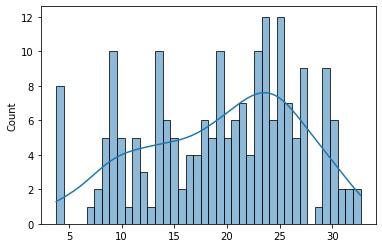

In [177]:
sns.histplot(y_holdout,bins=40,kde=True)

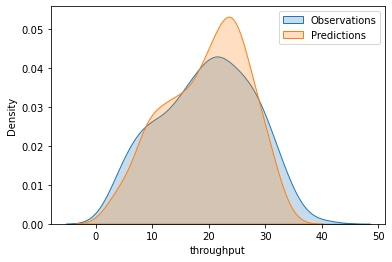

In [178]:
fig,ax = plt.subplots()

sns.kdeplot(y_test, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_holdout, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

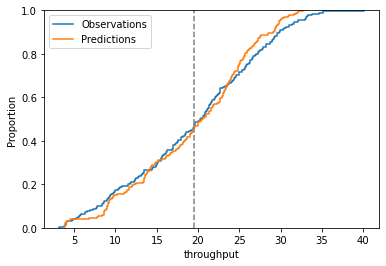

In [179]:
fig,ax = plt.subplots()

sns.ecdfplot(y_test, ax=ax, label='Observations')
sns.ecdfplot(y_holdout, ax=ax,label='Predictions')
plt.axvline(x=y_test.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [180]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_holdout)
mse = mean_squared_error(y_test,y_holdout)
rmse = np.sqrt(mse)

In [181]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,rf-no
MAE,3.083399
MSE,17.535033
RMSE,4.187485


In [182]:
# err_df.to_csv(f'./holdout-test/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [183]:
res = y_test - y_holdout
res.describe().drop('count')

mean     0.079407
std      4.197345
min    -12.057119
25%     -2.252665
50%      0.111840
75%      2.307734
max     18.968845
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

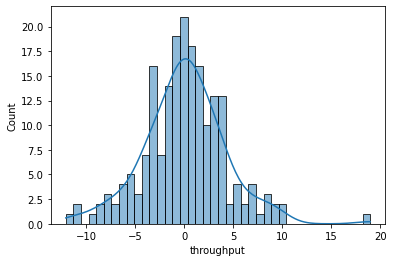

In [184]:
sns.histplot(data=res, kde=True,bins=40)

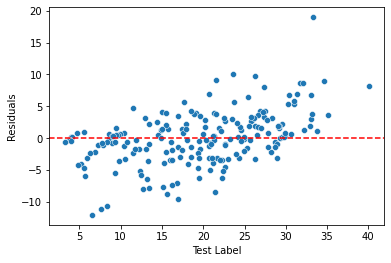

In [185]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

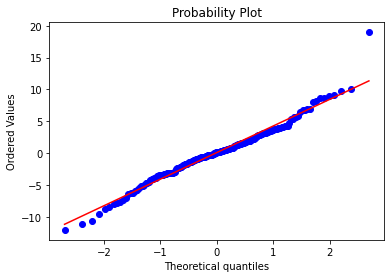

In [186]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

# Export Optimized Model

In [187]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X)

RobustScaler()

In [188]:
# MODIFY! 
X = scaler.transform(X)

op_model = score_model

op_model.fit(X,y)

RandomForestRegressor()

In [189]:
y_pred = op_model.predict(X)

<AxesSubplot:ylabel='Count'>

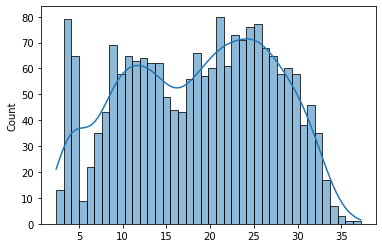

In [190]:
sns.histplot(y_pred,bins=40,kde=True)

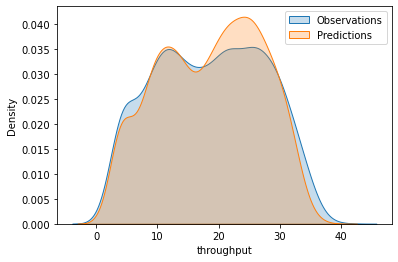

In [191]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

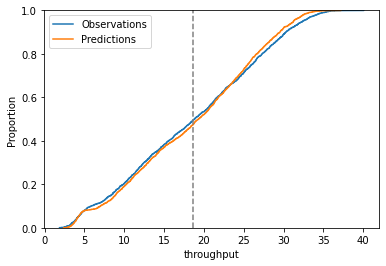

In [192]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [193]:
mae = mean_absolute_error(y,y_pred)
mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)

In [194]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,rf-no
MAE,1.004810
MSE,2.020758
RMSE,1.421534


In [195]:
# err_df.to_csv(f'./model-err/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [196]:
from joblib import dump, load
dump(op_model, f'./opt-models/{model_name}.joblib')

['./opt-models/rf-no.joblib']

In [197]:
res = y - y_pred
res.describe().drop('count')

mean   -0.018261
std     1.421776
min    -9.141288
25%    -0.690665
50%     0.029751
75%     0.748109
max     8.042887
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

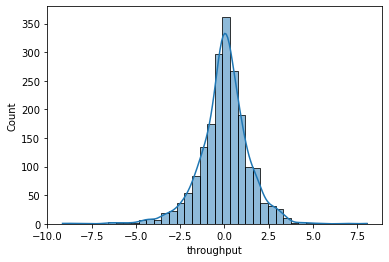

In [198]:
sns.histplot(data=res, kde=True,bins=40)

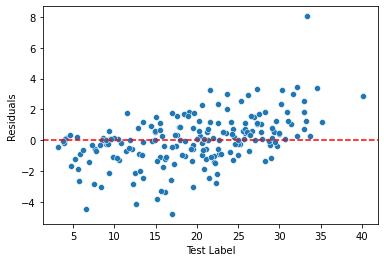

In [199]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

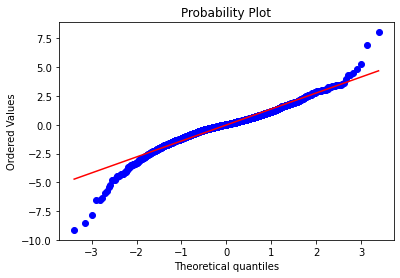

In [200]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

DONE!